In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob
from pprint import pprint

In [2]:
import matplotlib
matplotlib.__version__

'3.2.1'

In [3]:
def matchx(xvals, yvals, y):
    xub = xvals[0]
    for (xx, yy) in zip(xvals, yvals):
        if yy < max(y, 0.0001):
            break
        xub = xx
    return xub

In [4]:
methods = ['HGB', 'SVM-prescale', 'MLP-adam-prescale']
all_dfs = []
reps = 1
nsamples = 100
for method in methods:
    suffix = '_hp_bacc_iid3p_F10'
    assert os.path.isdir(method)
    all_resdir = glob(f'{method}/*{suffix}')
    print(f'Found {len(all_resdir)} directories with results')
    no_pkf = 0
    for resdir in all_resdir:
        if not os.path.isfile(os.path.join(resdir, 'final_stats.pkl')):
            no_pkf += 1
            print(f'- no results file for {resdir}')
    print(f'{no_pkf}/{len(all_resdir)} directories dont have final stats')

    all_res = []

    for resdir in all_resdir:
        assert os.path.isdir(resdir)
        print(f'Processing {resdir}')
        dname = resdir.split('/')[1].replace(suffix, '')

        pkfile = os.path.join(resdir, 'final_stats.pkl')
        if not os.path.isfile(pkfile):
            print(f'Missing pickle file {pkfile} ... skipping this data set')
            if dname != 'pc3':
                continue

        try:
            with open(pkfile, 'rb') as pkf:
                full_res = pickle.load(pkf)
            hpofile = os.path.join(resdir, 'hp_balanced_accuracy_pairs_data__full.csv')
            has_header = True
        except Exception as e:
            assert dname == 'pc3' and method == 'HGB'
            full_res = {
                'best_possible': 0.6381,
                'default': {'metric': 0.5899},
                'obj_global_mean': {'regret': 0.66},
                'obj_global_ucb': {'regret': 0.72},
                'obj_locals_max': {'regret': 0.39},
                'obj_locals_mean': {'regret': 0.38},
            }
            hpofile = os.path.join(resdir, 'hp_bacc_pairs_data_party_full.csv')
            has_header = False
        assert os.path.isfile(hpofile)


        full_hpo = pd.read_csv(hpofile) if has_header else pd.read_csv(hpofile, header=None)
        if not has_header:
            full_hpo.columns = [*[f'HP{i}' for i in range(full_hpo.shape[1]-1)], 'label']
        full_hpo['metric'] = -full_hpo['label']

        if 'best_possible' in full_res:
            assert np.isclose(full_res['best_possible'], full_hpo['metric'].max(), atol=1e-4),(
                f"V1: {full_res['best_possible']}, V2: {full_hpo['metric'].max()}"
            )
        else:
            full_res['best_possible'] = full_hpo['metric'].max()
        if 'metric' not in full_res['default']:
            assert 'skfold' in full_res['default']
            full_res['default']['metric'] = np.mean(full_res['default']['skfold'])
        gap = full_res['best_possible'] - full_res['default']['metric']
        for k, v in full_res.items():
            if 'obj_' in k:
                if 'regret' not in v:
                    assert 'skfold' in v
                    m = (full_res['best_possible'] - np.mean(v['skfold']))/gap
                    v['regret'] = m

        full_hpo['regret'] = (full_res['best_possible'] - full_hpo['metric']) / gap
        full_hpo['cum_regret'] = np.minimum.accumulate(full_hpo['regret'].values)

        for k, v in full_res.items():
            if 'obj_' in k:
                slist = []
                for i in range(reps):
                    yvals = full_hpo['cum_regret'].values[:nsamples]
                    if reps > 1:
                        yvals2 = yvals[np.sort(np.random.choice(len(yvals), nsamples, replace=True))]
                    else:
                        yvals2 = yvals[:nsamples]
                    xvals = np.arange(len(yvals2))+1
                    xub = matchx(xvals, yvals2, v['regret'])
                    slist += [xub]
                print(dname, k, slist)
                all_res += [(dname, k.replace('obj_', ''), np.mean(slist).astype(np.int), v['regret'])]
    #     break
#     pprint(all_res)
    df = pd.DataFrame(all_res, columns=['Data', 'LS', 'Speedup', 'Regret'])

    ddict = {'Data': None}
    for l, ldf in df.groupby('LS'):
        if ddict['Data'] is None:
            ddict['Data'] = ldf['Data'].values
        ddict[l] = ldf['Speedup'].values
        ddict[f'{l}-xx'] = ldf['Regret'].values
    fdf = pd.DataFrame.from_dict(ddict)
    display(method, fdf)

    for c in fdf.columns:
        if c == 'Data':
            continue
        vals = fdf[c].values
        mean = np.mean(vals)
        std = np.std(vals)
        median = np.percentile(vals, q=50)
        fq = np.percentile(vals, q=25)
        tq = np.percentile(vals, q=75)
        print(f'[{c}]Mean: {mean:.2f}, std: {std:.2f}, [{fq:.2f}, {median:.2f}, {tq:.2f}]')
    all_dfs += [fdf]

Found 7 directories with results
- no results file for HGB/pc3_hp_bacc_iid3p_F10
1/7 directories dont have final stats
Processing HGB/pollen_hp_bacc_iid3p_F10
pollen obj_global_mean [9]
pollen obj_global_ucb [8]
pollen obj_locals_max [9]
pollen obj_locals_mean [8]
Processing HGB/elec_norm_hp_bacc_iid3p_F10
elec_norm obj_global_mean [24]
elec_norm obj_global_ucb [24]
elec_norm obj_locals_max [28]
elec_norm obj_locals_mean [24]
Processing HGB/sonar_hp_bacc_iid3p_F10
sonar obj_global_mean [3]
sonar obj_global_ucb [33]
sonar obj_locals_max [3]
sonar obj_locals_mean [3]
Processing HGB/heart_statlog_hp_bacc_iid3p_F10
heart_statlog obj_global_mean [8]
heart_statlog obj_global_ucb [8]
heart_statlog obj_locals_max [8]
heart_statlog obj_locals_mean [8]
Processing HGB/oil_spill_hp_bacc_iid3p_F10
oil_spill obj_global_mean [2]
oil_spill obj_global_ucb [1]
oil_spill obj_locals_max [2]
oil_spill obj_locals_mean [1]
Processing HGB/eeg_eye_hp_bacc_iid3p_F10
eeg_eye obj_global_mean [4]
eeg_eye obj_globa

'HGB'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,9,0.431855,8,0.541338,9,0.425455,8,0.688496
1,elec_norm,24,0.171246,24,0.138590,28,0.094168,24,0.123606
2,sonar,3,1.332011,33,0.407407,3,0.921958,3,0.710317
3,heart_statlog,8,0.689189,8,0.554054,8,0.891892,8,0.500000
4,oil_spill,2,0.471827,1,1.132056,2,0.455067,1,0.613773
5,eeg_eye,4,0.139188,4,0.124921,4,0.113035,4,0.117685
6,pc3,7,0.660000,7,0.720000,30,0.390000,30,0.380000


[global_mean]Mean: 8.14, std: 6.92, [3.50, 7.00, 8.50]
[global_mean-xx]Mean: 0.56, std: 0.37, [0.30, 0.47, 0.67]
[global_ucb]Mean: 12.14, std: 10.87, [5.50, 8.00, 16.00]
[global_ucb-xx]Mean: 0.52, std: 0.32, [0.27, 0.54, 0.64]
[locals_max]Mean: 12.00, std: 11.02, [3.50, 8.00, 18.50]
[locals_max-xx]Mean: 0.47, std: 0.31, [0.25, 0.43, 0.67]
[locals_mean]Mean: 11.14, std: 10.43, [3.50, 8.00, 16.00]
[locals_mean-xx]Mean: 0.45, std: 0.23, [0.25, 0.50, 0.65]
Found 6 directories with results
0/6 directories dont have final stats
Processing SVM-prescale/pollen_hp_bacc_iid3p_F10
pollen obj_global_mean [1]
pollen obj_global_ucb [1]
pollen obj_locals_max [1]
pollen obj_locals_mean [1]
Processing SVM-prescale/sonar_hp_bacc_iid3p_F10
sonar obj_global_mean [20]
sonar obj_global_ucb [20]
sonar obj_locals_max [11]
sonar obj_locals_mean [20]
Processing SVM-prescale/heart_statlog_hp_bacc_iid3p_F10
heart_statlog obj_global_mean [100]
heart_statlog obj_global_ucb [100]
heart_statlog obj_locals_max [1]
hea

'SVM-prescale'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,1,1.354929,1,1.449885,1,2.839927,1,2.300363
1,sonar,20,0.166203,20,0.166203,11,0.270428,20,0.166203
2,heart_statlog,100,0.000000,100,0.000000,1,6.800000,11,0.666667
3,oil_spill,1,1.280647,1,1.162679,4,1.117802,33,0.412968
4,eeg_eye,100,-0.007966,100,-0.008961,100,-0.015710,100,-0.008151
5,pc3,6,0.593560,6,0.790897,6,0.702147,6,0.790897


[global_mean]Mean: 38.00, std: 44.30, [2.25, 13.00, 80.00]
[global_mean-xx]Mean: 0.56, std: 0.57, [0.04, 0.38, 1.11]
[global_ucb]Mean: 38.00, std: 44.30, [2.25, 13.00, 80.00]
[global_ucb-xx]Mean: 0.59, std: 0.58, [0.04, 0.48, 1.07]
[locals_max]Mean: 20.50, std: 35.72, [1.75, 5.00, 9.75]
[locals_max-xx]Mean: 1.95, std: 2.35, [0.38, 0.91, 2.41]
[locals_mean]Mean: 28.50, std: 33.60, [7.25, 15.50, 29.75]
[locals_mean-xx]Mean: 0.72, std: 0.76, [0.23, 0.54, 0.76]
Found 7 directories with results
0/7 directories dont have final stats
Processing MLP-adam-prescale/pollen_hp_bacc_iid3p_F10
pollen obj_global_mean [1]
pollen obj_global_ucb [6]
pollen obj_locals_max [6]
pollen obj_locals_mean [8]
Processing MLP-adam-prescale/elec_norm_hp_bacc_iid3p_F10
elec_norm obj_global_mean [65]
elec_norm obj_global_ucb [39]
elec_norm obj_locals_max [65]
elec_norm obj_locals_mean [39]
Processing MLP-adam-prescale/sonar_hp_bacc_iid3p_F10
sonar obj_global_mean [21]
sonar obj_global_ucb [5]
sonar obj_locals_max [5

'MLP-adam-prescale'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,1,1.883710,6,1.450507,6,1.450507,8,1.306002
1,elec_norm,65,0.235201,39,0.409378,65,0.161673,39,0.532399
2,sonar,21,0.256458,5,0.552876,5,0.520480,12,0.387327
3,heart_statlog,5,0.461538,5,0.371795,5,0.416667,10,0.282051
4,oil_spill,3,0.796153,1,1.029203,1,1.000000,3,0.785202
5,eeg_eye,45,0.988319,20,0.992760,20,0.992760,20,0.992760
6,pc3,1,0.956965,1,1.000000,1,0.892545,1,0.902718


[global_mean]Mean: 20.14, std: 23.56, [2.00, 5.00, 33.00]
[global_mean-xx]Mean: 0.80, std: 0.53, [0.36, 0.80, 0.97]
[global_ucb]Mean: 11.00, std: 12.88, [3.00, 5.00, 13.00]
[global_ucb-xx]Mean: 0.83, std: 0.37, [0.48, 0.99, 1.01]
[locals_max]Mean: 14.71, std: 21.37, [3.00, 5.00, 13.00]
[locals_max-xx]Mean: 0.78, std: 0.40, [0.47, 0.89, 1.00]
[locals_mean]Mean: 13.29, std: 11.97, [5.50, 10.00, 16.00]
[locals_mean-xx]Mean: 0.74, std: 0.34, [0.46, 0.79, 0.95]


# Figure 1 

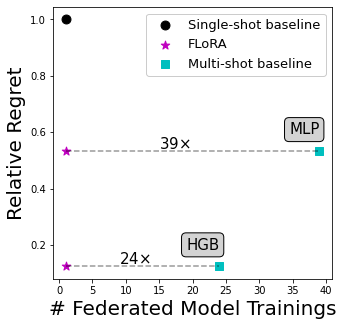

In [5]:
dnlist = {
    'pollen': 'Pollen',
    'elec_norm': 'Electricity',
    'sonar': 'Sonar',
    'heart_statlog': 'Heart Statlog',
    'oil_spill': 'Oil Spill',
    'eeg_eye': 'EEG Eye State',
    'pc3': 'PC3',
}
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True, squeeze=True)
dname = 'elec_norm'
lsname = 'locals_mean'
axs.set_ylabel('Relative Regret', fontsize=20)
axs.set_xlabel('# Federated Model Trainings', fontsize=20)
#axs.set_title(dnlist[dname], fontsize=25)
do_label = True
# axs.grid(axis='both')
axs.scatter(1, 1, marker='o', s=80, color='k', label='Single-shot baseline')
for m, df in zip(methods, all_dfs):
    # display(m, df)
    if dname not in df['Data'].values:
        continue
    ddf = df[df['Data'] == dname]
    ncols = (df.shape[1] - 1)//2    
    for i in range(ncols):
        ls = ddf.columns[2*i+1]
        if ls != lsname:
            continue
        yvals = ddf.iloc[:, 2*(i+1)].values
        xvals = ddf.iloc[:, 2*i+1].values
        assert len(yvals) == 1 and len(xvals) == 1, f'X: {len(xvals)}, Y: {len(yvals)}'
        for yy, xx in sorted(zip(yvals, xvals)):
            axs.plot([1, xx], [yy, yy], '--', color='k', alpha=0.4)
            axs.scatter(1, yy, marker='*', color='m', s=80, label='FLoRA' if do_label else None)
            axs.scatter(xx, yy, marker='s', color='c', s=80, label='Multi-shot baseline' if do_label else None)
            axs.text(
                xx, yy+0.05, m.split('-')[0], ha="right", va="bottom", rotation=0, size=15,
                bbox=dict(boxstyle="round,pad=0.3", fc="lightgray")
            )
            axs.text(xx//(2.5), yy+0.01, f'{xx}'+r'$\times$', size=15)
            do_label = False
axs.legend(loc='upper right', fontsize=13, framealpha=1.)
plt.show()
#     break

# Figure 2

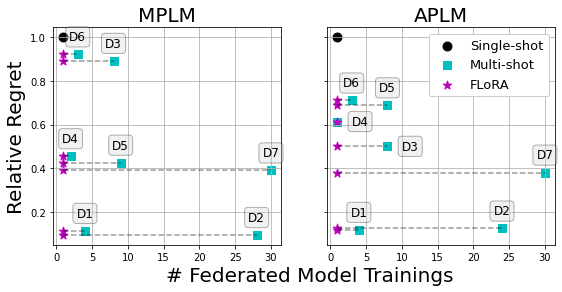

In [6]:
lsdict = {
    'global_mean': 'SGM',
    'global_ucb': 'SGM+U',
    'locals_max': 'MPLM',
    'locals_mean': 'APLM',
}
dnlist = {
    'pollen': 'Pollen',
    'elec_norm': 'Electricity',
    'sonar': 'Sonar',
    'heart_statlog': 'Heart Statlog',
    'oil_spill': 'Oil Spill',
    'eeg_eye': 'EEG Eye State',
    'pc3': 'PC3',
}
dnlist = {
    'pollen': 'Pollen',
    'elec_norm': 'Elec',
    'sonar': 'Sonar',
    'heart_statlog': 'HStat',
    'oil_spill': 'OilSp',
    'eeg_eye': 'EEG',
    'pc3': 'PC3',
}
dnlist = {
    'pollen': 'D5',
    'elec_norm': 'D2',
    'sonar': 'D6',
    'heart_statlog': 'D3',
    'oil_spill': 'D4',
    'eeg_eye': 'D1',
    'pc3': 'D7',
}
lsnames = ['locals_max', 'locals_mean']
method = 'HGB'
fig, axs = plt.subplots(
    1, len(lsnames),
    figsize=(9, 4),
    sharex=True, sharey=True,
    squeeze=True
)
axs[0].set_ylabel('Relative Regret', fontsize=20)
# axs[0].set_xlabel('# Federated Model Trainings', fontsize=20)
# fig.supylabel('Relative Regret', fontsize=20)
fig.text(0.3, 0, '# Federated Model Trainings', fontsize=20)
#axs.set_title(dnlist[dname], fontsize=25)
# axs.grid(axis='both')
for m, df in zip(methods, all_dfs):
    if m != method:
        continue
    ncols = (df.shape[1] - 1)//2
    plt_idx = 0
    for i in range(ncols):
        ls = df.columns[2*i+1]
        if ls not in lsnames:
            continue
        ax = axs[plt_idx]
        ax.scatter(1, 1, marker='o', s=80, color='k', label='Single-shot')
        yvals = df.iloc[:, 2*(i+1)].values
        xvals = df.iloc[:, 2*i+1].values
        dnames = df.iloc[:, 0].values
        do_label = True
        for yy, xx, d in sorted(zip(yvals, xvals, dnames)):
            ax.plot([1, xx], [yy, yy], '--', color='k', alpha=0.4)
            ax.scatter(xx, yy, marker='s', color='c', s=80, label='Multi-shot' if do_label else None)
            ax.scatter(1, yy, marker='*', color='m', s=80, label='FLoRA' if do_label else None)
            if dnlist[d] in ['D3', 'D4'] and ls == 'locals_mean':
                ax.text(
                    xx+2, yy,
                    dnlist[d],
                    ha="left",
                    va="center",
                    rotation=0, size=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", alpha=0.3)
                )
            else:
                ax.text(
                    xx, yy+0.05,
                    dnlist[d],
                    ha="center",
                    va="bottom",
                    rotation=0, size=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", alpha=0.3)
                )
            # axs.text(xx//(2.5), yy+0.01, f'{xx}'+r'$\times$', size=15)
            do_label = False
        ax.grid(axis='both')
        plt_idx += 1
        ax.set_title(lsdict[ls], fontsize=20)
axs[-1].legend(loc='upper right', fontsize=13, framealpha=1.)
plt.show()
#     break

# Figures 4, 5, 6

'HGB'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,9,0.431855,8,0.541338,9,0.425455,8,0.688496
1,elec_norm,24,0.171246,24,0.138590,28,0.094168,24,0.123606
2,sonar,3,1.332011,33,0.407407,3,0.921958,3,0.710317
3,heart_statlog,8,0.689189,8,0.554054,8,0.891892,8,0.500000
4,oil_spill,2,0.471827,1,1.132056,2,0.455067,1,0.613773
5,eeg_eye,4,0.139188,4,0.124921,4,0.113035,4,0.117685
6,pc3,7,0.660000,7,0.720000,30,0.390000,30,0.380000


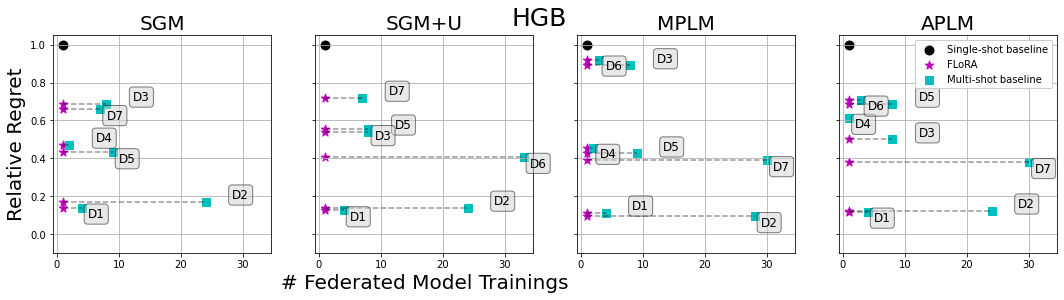

'SVM-prescale'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,1,1.354929,1,1.449885,1,2.839927,1,2.300363
1,sonar,20,0.166203,20,0.166203,11,0.270428,20,0.166203
2,heart_statlog,100,0.000000,100,0.000000,1,6.800000,11,0.666667
3,oil_spill,1,1.280647,1,1.162679,4,1.117802,33,0.412968
4,eeg_eye,100,-0.007966,100,-0.008961,100,-0.015710,100,-0.008151
5,pc3,6,0.593560,6,0.790897,6,0.702147,6,0.790897


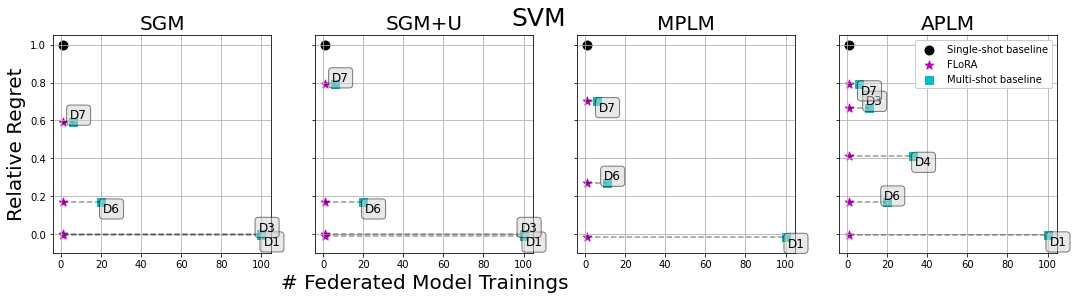

'MLP-adam-prescale'

,Data,global_mean,global_mean-xx,global_ucb,global_ucb-xx,locals_max,locals_max-xx,locals_mean,locals_mean-xx
0,pollen,1,1.883710,6,1.450507,6,1.450507,8,1.306002
1,elec_norm,65,0.235201,39,0.409378,65,0.161673,39,0.532399
2,sonar,21,0.256458,5,0.552876,5,0.520480,12,0.387327
3,heart_statlog,5,0.461538,5,0.371795,5,0.416667,10,0.282051
4,oil_spill,3,0.796153,1,1.029203,1,1.000000,3,0.785202
5,eeg_eye,45,0.988319,20,0.992760,20,0.992760,20,0.992760
6,pc3,1,0.956965,1,1.000000,1,0.892545,1,0.902718


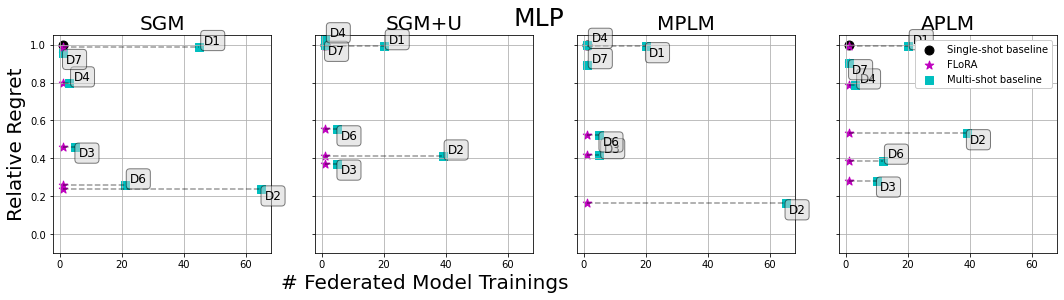

In [7]:
dnlist = {
    'pollen': 'Pollen',
    'elec_norm': 'Elec',
    'sonar': 'Sonar',
    'heart_statlog': 'HStat',
    'oil_spill': 'OilSp',
    'eeg_eye': 'EEG',
    'pc3': 'PC3',
}
dnlist = {
    'pollen': 'D5',
    'elec_norm': 'D2',
    'sonar': 'D6',
    'heart_statlog': 'D3',
    'oil_spill': 'D4',
    'eeg_eye': 'D1',
    'pc3': 'D7',
}
YLIM = 1.05
for m, df in zip(methods, all_dfs):
    display(m, df)
    ncols = (df.shape[1] - 1)//2
    fig, axs = plt.subplots(1, ncols, figsize=(18, 4), sharex=True, sharey=True, squeeze=True)
    fig.suptitle(m.split('-')[0], fontsize=25)
    axs[0].set_ylabel('Relative Regret', fontsize=20)
    axs[ncols//2-1].set_xlabel('# Federated Model Trainings', fontsize=20)
    for i in range(ncols):
        yvals = df.iloc[:, 2*(i+1)].values
        xvals = df.iloc[:, 2*i+1].values
        dnames = df.iloc[:, 0].values
        ax = axs[i]
        ls = df.columns[2*i+1]
        ax.set_title(lsdict[ls], fontsize=20)
        ax.grid(axis='both')
        ax.scatter(1, 1, marker='o', s=80, color='k', label='Single-shot baseline')
        do_label = True
        va_flag = True
        for yy, xx, d in sorted(zip(yvals, xvals, dnames)):
            ax.plot([1, xx], [yy, yy], '--', color='k', alpha=0.4)
            ax.scatter(1, yy, marker='*', color='m', s=80, label='FLoRA' if do_label else None)
            ax.scatter(xx, yy, marker='s', color='c', s=80, label='Multi-shot baseline' if do_label else None)
            #ax.annotate(text=dnlist[d], xy=(xx+1, yy))
            if yy > YLIM:
                continue
            ax.text(
                xx+(1 if va_flag else 7), yy, dnlist[d],
                ha="left" if va_flag else "right",
                va="top" if va_flag else "bottom",
                rotation=0, size=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", alpha=0.5)
            )
            va_flag = not va_flag
            do_label = False
        ax.set_ylim(-0.1, YLIM)
    axs[-1].legend(loc='upper right', fontsize=10, framealpha=1.)
    plt.show()
#     break